In [8]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred

In [367]:
batch_size = 4
seq_length = 6

In [408]:
with open("fred_key.txt", 'r') as f:
    key = f.read()


fred = Fred(api_key=key)

data_dict = {
    "CPIAUCSL": "CPI",
    "UNRATE": "Unemployment",
    "FEDFUNDS": "fed_rate"
}

def get_data(data_dict):
    data = {data_dict[code]: fred.get_series_latest_release(code) for code in data_dict}
    df = pd.DataFrame(data)
    return df

data = get_data(data_dict)
print(data.shape)
data.tail()

(926, 3)


,CPI,Unemployment,fed_rate
2023-10-01,307.531,3.8,5.33
2023-11-01,308.024,3.7,5.33
2023-12-01,308.742,3.7,5.33
2024-01-01,309.685,3.7,5.33
2024-02-01,311.054,3.9,5.33


In [23]:
def difference_data(df):
    df['log_inflation_MoM'] =  np.log(df["CPI"]).diff()
    df['fed_rate_DIFF'] = np.log(df["fed_rate"]).diff()
    df['Unemployment_DIFF'] = df["Unemployment"].diff()
    return df.dropna()

data_diff = difference_data(data)
print(data_diff.tail())

                CPI  Unemployment  fed_rate  log_inflation_MoM  fed_rate_DIFF  \
2023-10-01  307.531           3.8      5.33           0.000790            0.0   
2023-11-01  308.024           3.7      5.33           0.001602            0.0   
2023-12-01  308.742           3.7      5.33           0.002328            0.0   
2024-01-01  309.685           3.7      5.33           0.003050            0.0   
2024-02-01  311.054           3.9      5.33           0.004411            0.0   

            Unemployment_DIFF  
2023-10-01                0.0  
2023-11-01               -0.1  
2023-12-01                0.0  
2024-01-01                0.0  
2024-02-01                0.2  


<Axes: >

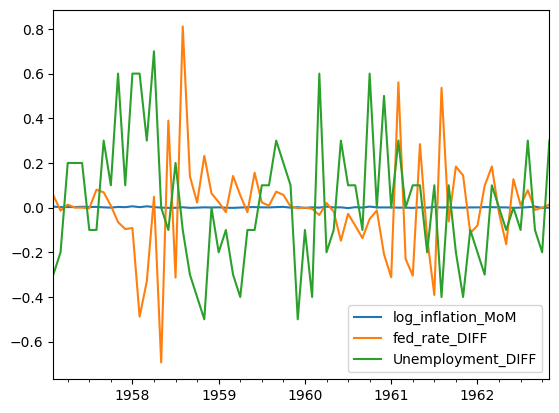

In [410]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[30:100].plot()

In [130]:
cutoff = int(data_diff.shape[0]*0.75)
data_diff.iloc[cutoff-1]

CPI                  202.800000
Unemployment           4.500000
fed_rate               5.250000
log_inflation_MoM     -0.004919
fed_rate_DIFF          0.000000
Unemployment_DIFF     -0.200000
Name: 2006-09-01 00:00:00, dtype: float64

In [368]:
class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, train=True, train_end_year=None, seq_length=3):
        self.seq_length = seq_length
        
        self.data_dict = {
            "CPIAUCSL": "CPI",
            "UNRATE": "Unemployment",
            "FEDFUNDS": "fed_rate"
        }
        
        data = get_data(self.data_dict)
        self.data = difference_data(data)[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]]
        
        if train:
            self.data = self.data.loc[:train_end_year]
        else:
            # Create test set after the train_end_year
            self.data = self.data.loc[pd.to_datetime(train_end_year) + pd.DateOffset(months=1):]
        
        # Convert to pytorch tensor
        self.data = torch.tensor(self.data.values)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length

In [369]:
from torch.utils.data import DataLoader

train_dataset = MonetaryPolicyDataSet(train=True, train_end_year="2006-09-01", seq_length = seq_length)
test_dataset = MonetaryPolicyDataSet(train=False, train_end_year="2006-09-01", seq_length = seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[-3.7237e-04,  4.2199e-01,  2.0000e-01],
         [-1.4909e-03, -1.3119e-01,  1.0000e-01],
         [-3.3626e-03, -2.3018e-01, -4.0000e-01],
         [ 2.2430e-03, -2.3811e-02, -4.0000e-01],
         [-3.7348e-04,  4.3319e-01, -3.0000e-01],
         [ 0.0000e+00,  8.2444e-02, -1.0000e-01]],

        [[-1.4909e-03, -1.3119e-01,  1.0000e-01],
         [-3.3626e-03, -2.3018e-01, -4.0000e-01],
         [ 2.2430e-03, -2.3811e-02, -4.0000e-01],
         [-3.7348e-04,  4.3319e-01, -3.0000e-01],
         [ 0.0000e+00,  8.2444e-02, -1.0000e-01],
         [ 1.8660e-03, -7.4662e-02, -2.0000e-01]],

        [[-3.3626e-03, -2.3018e-01, -4.0000e-01],
         [ 2.2430e-03, -2.3811e-02, -4.0000e-01],
         [-3.7348e-04,  4.3319e-01, -3.0000e-01],
         [ 0.0000e+00,  8.2444e-02, -1.0000e-01],
         [ 1.8660e-03, -7.4662e-02, -2.0000e-01],
         [-1.1192e-03,  4.5462e-02, -1.0000e-01]],

        [[ 2.2430e-03, -2.3811e-02, -4.0000e-01],
         [-3.7348e-04,  4.3319e-01, -3.0000e

In [254]:
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[-0.0044,  0.0000, -0.1000],
         [ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000]],

        [[ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000]],

        [[ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000]],

        [[ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000],
         [ 0.0052,  0.0000, -0.1000]]], dtype=torch.float64)


In [397]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 1, bias=True)
        self.sigmoid = torch.nn.Sigmoid()
        #self.fc2 = torch.nn.Linear(20, 1, bias=False)
        
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x)
        return x
        

## Test forward

In [398]:
# Test forward pass
model = RNNModel(seq_length, 20)

test_input = x[0:2].float().transpose(1,2)
print("Input:")
print(test_input)

with torch.no_grad():
    print("Output: ")
    print(model(test_input).reshape(-1, 3))
    print(y[0:2])

Input:
tensor([[[-3.7237e-04, -1.4909e-03, -3.3626e-03,  2.2430e-03, -3.7348e-04,
           0.0000e+00],
         [ 4.2199e-01, -1.3119e-01, -2.3018e-01, -2.3811e-02,  4.3319e-01,
           8.2444e-02],
         [ 2.0000e-01,  1.0000e-01, -4.0000e-01, -4.0000e-01, -3.0000e-01,
          -1.0000e-01]],

        [[-1.4909e-03, -3.3626e-03,  2.2430e-03, -3.7348e-04,  0.0000e+00,
           1.8660e-03],
         [-1.3119e-01, -2.3018e-01, -2.3811e-02,  4.3319e-01,  8.2444e-02,
          -7.4662e-02],
         [ 1.0000e-01, -4.0000e-01, -4.0000e-01, -3.0000e-01, -1.0000e-01,
          -2.0000e-01]]])
Output: 
tensor([[0.0121, 0.0096, 0.1053],
        [0.0118, 0.0941, 0.0201]])
tensor([[ 0.0019, -0.0747, -0.2000],
        [-0.0011,  0.0455, -0.1000]], dtype=torch.float64)


In [324]:
mse = nn.MSELoss()
mse(model(test_input).reshape(-1, 3), y[0:2])

tensor(0.0882, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [402]:
from torch import optim
import torch.nn as nn
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Trainer:
    def __init__(self,
                 n_epoch:int,
                 train_loader,
                 validation_loader):

        self.n_epoch = n_epoch

        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.net = RNNModel(seq_length, 5)
        self.net.to(device)
        self.optimizer = optim.Adam(lr=0.001, params=self.net.parameters()) #optim.Adam(lr=0.001, params=self.net.parameters())
        self.loss = nn.MSELoss()


        
    def train(self):
        self.epoch_error = []
        self.val_error = []
        for epoch in range(1, self.n_epoch + 1):
            error = self.train_loop(epoch)
            self.epoch_error.append(error)
            print("epoch error",error)
            val_error =self.validation()
            self.val_error.append(val_error)
        
        
    def train_loop(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(device).float().transpose(1,2)
            y = y.to(device).float()
            self.optimizer.zero_grad()

            output = self.net(x).reshape(-1,3)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()

            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))


        return np.mean(losses)

    
    def validation(self):
        val_loss_list = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(device).float().transpose(1,2)
            y = y.to(device).float()
            with torch.no_grad():
                validation_output = self.net(x).reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                val_loss_list.append(loss_val.item())
                #print("predicted:", vfunc(chars), "target:", vfunc(y_pos))
                if idx % log_interval==0:
                    print("Validation_loss: {}".format(loss_val.item()))
                    
        return np.mean(val_loss_list)

            


trainer = Trainer(100, train_dataloader, test_dataloader)
trainer.train()

Train Epoch: 1 [0/620 (0%)]	Loss: 0.063564
Train Epoch: 1 [400/620 (65%)]	Loss: 0.010742
epoch error 0.016744094105407354
Validation_loss: 0.005582471378147602
Train Epoch: 2 [0/620 (0%)]	Loss: 0.019871
Train Epoch: 2 [400/620 (65%)]	Loss: 0.010364
epoch error 0.013955118757627545
Validation_loss: 0.005924534983932972
Train Epoch: 3 [0/620 (0%)]	Loss: 0.017708
Train Epoch: 3 [400/620 (65%)]	Loss: 0.010396
epoch error 0.013639202171320756
Validation_loss: 0.006020653527230024
Train Epoch: 4 [0/620 (0%)]	Loss: 0.016805
Train Epoch: 4 [400/620 (65%)]	Loss: 0.010418
epoch error 0.013495027920561693
Validation_loss: 0.0060508158057928085
Train Epoch: 5 [0/620 (0%)]	Loss: 0.016345
Train Epoch: 5 [400/620 (65%)]	Loss: 0.010413
epoch error 0.013430884640453564
Validation_loss: 0.0060616713017225266
Train Epoch: 6 [0/620 (0%)]	Loss: 0.016087
Train Epoch: 6 [400/620 (65%)]	Loss: 0.010390
epoch error 0.013402601741554757
Validation_loss: 0.006063950713723898
Train Epoch: 7 [0/620 (0%)]	Loss: 0.01

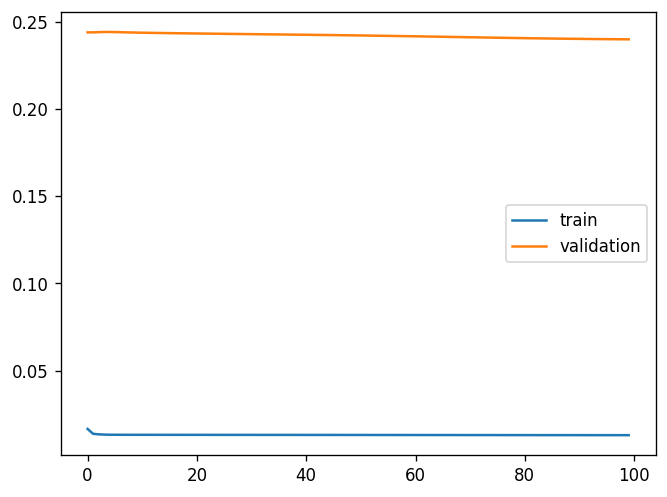

In [403]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(trainer.epoch_error)), trainer.epoch_error, label='train')
ax.plot(np.arange(len(trainer.val_error)), trainer.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

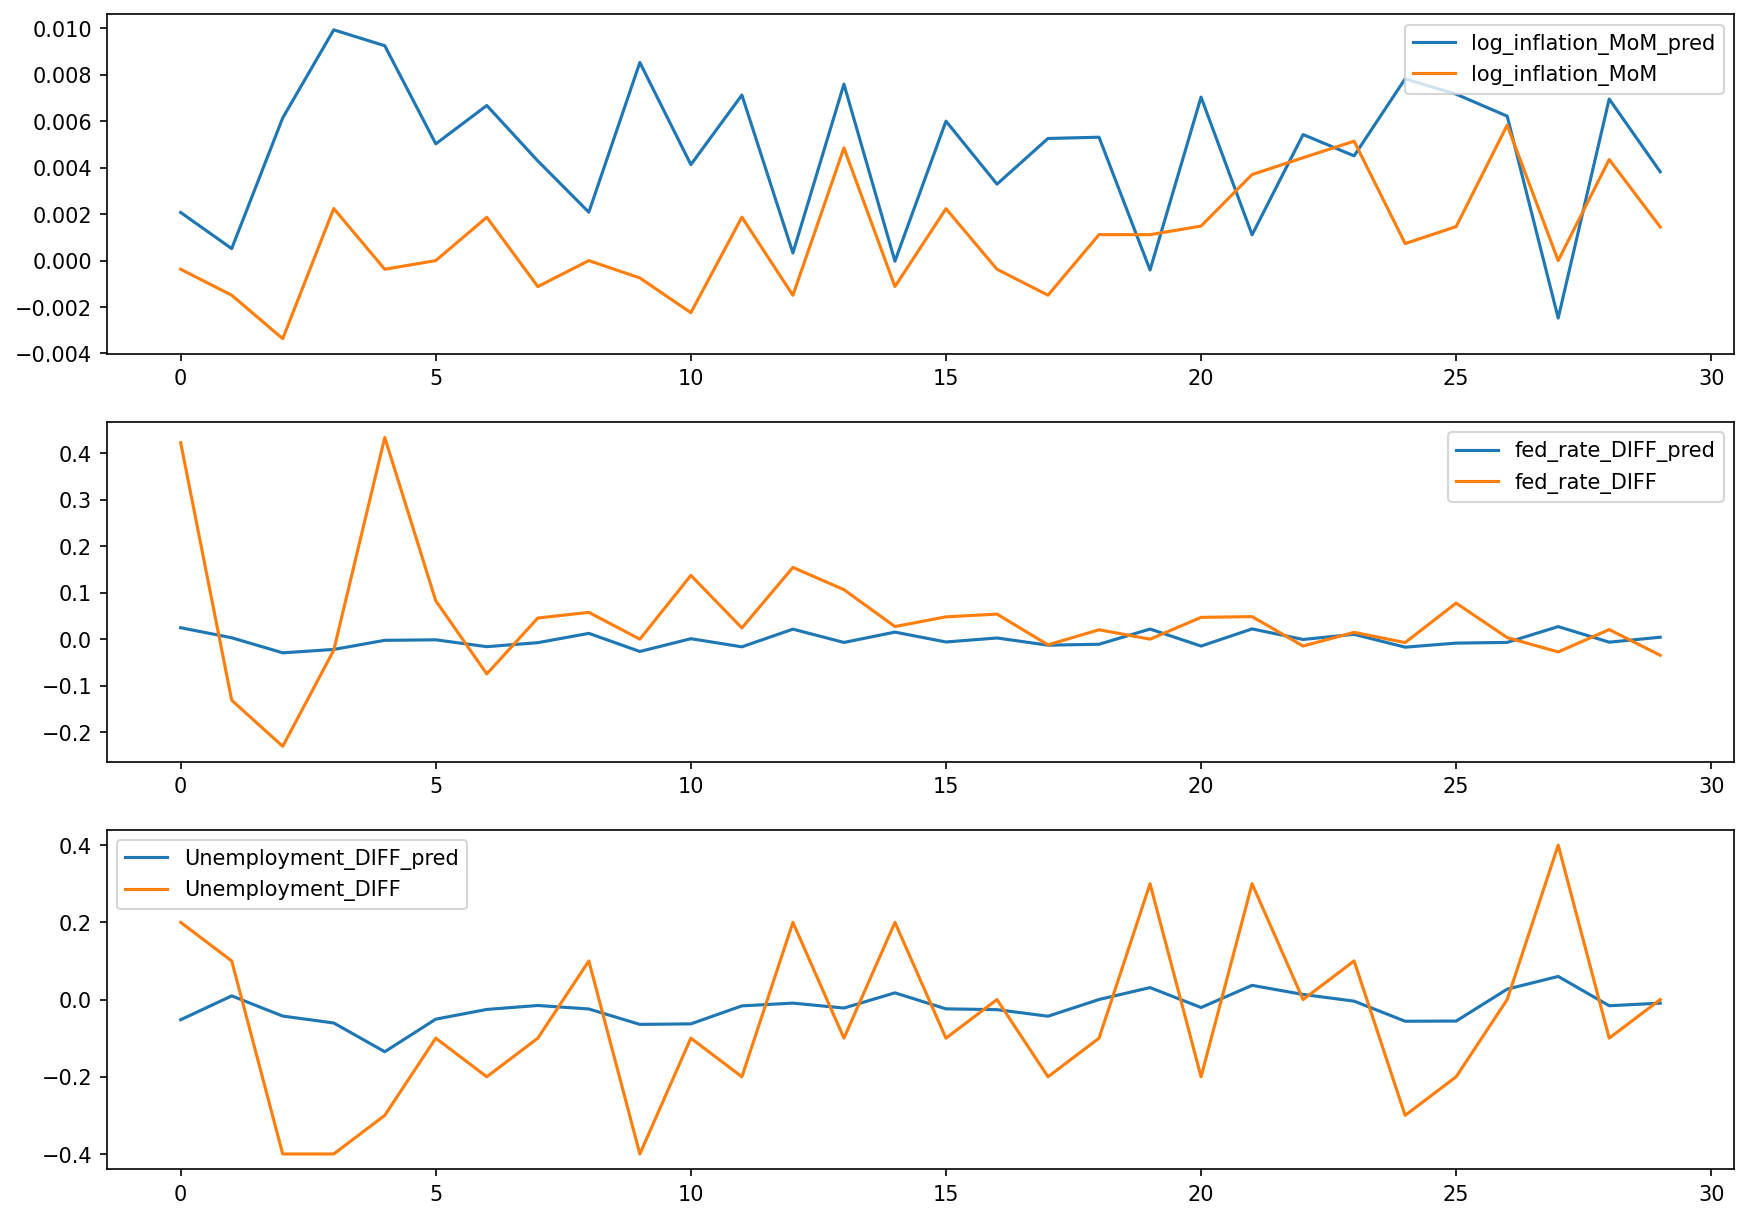

In [405]:

def plot_predictions(n):
    model_trained = trainer.net
    
    predictions = []
    with torch.no_grad():
        for idx, (x, y) in enumerate(train_dataloader):
            pred = model_trained(x.to(device).float().transpose(1,2))
            predictions.append(pred)
            
    predictions_df = pd.DataFrame(p, columns = ["log_inflation_MoM_pred", "fed_rate_DIFF_pred", "Unemployment_DIFF_pred"])
    
    fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))
    all_data=pd.concat([data_diff.reset_index(), predictions_df], ignore_index=False, axis=1)
    all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]].iloc[:n].plot(ax=axs[0])
    all_data[["fed_rate_DIFF_pred", "fed_rate_DIFF"]].iloc[:n].plot(ax=axs[1])
    all_data[["Unemployment_DIFF_pred", "Unemployment_DIFF"]].iloc[:n].plot(ax=axs[2])
    
plot_predictions(30)